In [1]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
import json
import joblib as joblib

import re
import string
import dill 

In [2]:
# nltk.download('punkt')
# pip install unidecode
from unidecode import unidecode

In [3]:
# Load data
data_train = pd.read_csv('../../Data Splits/train_data_70_30.csv')
data_test = pd.read_csv('../../Data Splits/test_data_70_30.csv')

In [4]:
X_train = data_train['article']
y_train = data_train['label']

X_test = data_test['article']
y_test = data_test['label']

In [5]:
# Stopword Removal
ps = PorterStemmer()
with open('../../Datasets/stopwords-tl.json', 'r') as f:
    stopwords = json.load(f)
    
def preprocess(text):
    if isinstance(text, str):  # If it's a single string
        text = [text]  # Convert to a list of one string for consistency

    processed_texts = []
    for item in text:
        # Lowercase Conversion
        lowered = item.lower()

        # URL Removal
        urled = re.sub(r'https?://\S+|www\.\S+', '', lowered)
        
        # Text Simplification
        simplified = re.sub(r'\[.*?\]', '', urled)
        simplified = re.sub(r"\\W", " ", simplified)
        simplified = re.sub(r'<.*?>+', '', simplified)
        simplified = re.sub(r'[%s]' % re.escape(string.punctuation), '', simplified)
        simplified = re.sub(r'\n', '', simplified)
        simplified = re.sub(r'\w*\d\w*', '', simplified)

        # Tokenization
        tokens = nltk.word_tokenize(simplified)
        stems = [ps.stem(token) for token in tokens]
        filtered = [stem for stem in stems if stem not in stopwords]
        
        processed_texts.append(filtered)

    if len(processed_texts) == 1:
        return processed_texts[0]  # Return the single processed text
    else:
        return processed_texts  # Return the list of processed texts


In [6]:
# Apply preprocess function to X_train
X_train_preprocessed = X_train.apply(preprocess)

# Apply preprocess function to X_val
X_test_preprocessed = X_test.apply(preprocess)

# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train_preprocessed.apply(lambda x: ' '.join(x)))
X_test_tfidf = vectorizer.transform(X_test_preprocessed.apply(lambda x: ' '.join(x)))

In [8]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']

# Define the parameter grid
param_grid = {'penalty': ['l2'], 'C': [1, 10, 100, 1000], 'solver': ['lbfgs', 'liblinear']}

In [9]:
lr_grid = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Fit the pipeline on the training data
lr_grid.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='accuracy')

In [12]:
best_meta = lr_grid.best_estimator_
joblib.dump(lr_grid, '../../ModelsV3/gridsearch_lr.joblib')

['../../ModelsV3/gridsearch_lr.joblib']

In [14]:
print("Best Hyperparameters: ", lr_grid.best_params_)
print("Best Accuracy: {:.2f}%".format(lr_grid.best_score_ * 100))

Best Hyperparameters:  {'C': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best Accuracy: 94.63%


In [15]:
stack = StackingClassifier(estimators=list(zip(base_names, base_models)), final_estimator=best_meta ,cv=5)
stack.fit(X_train_tfidf, y_train)

StackingClassifier(cv=5,
                   estimators=[('MNB', MultinomialNB()),
                               ('LR', LogisticRegression()),
                               ('RF', RandomForestClassifier()),
                               ('KNN', KNeighborsClassifier()),
                               ('SVM', SVC(probability=True))],
                   final_estimator=LogisticRegression(C=1000,
                                                      solver='liblinear'))

Metrics for MNB:
Accuracy: 0.8370288248337029
Precision: 0.7602040816326531
Recall: 0.9867549668874173
F1 Score: 0.8587896253602305
AUC: 0.9768383997797411
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.69      0.81       449
           1       0.76      0.99      0.86       453

    accuracy                           0.84       902
   macro avg       0.87      0.84      0.83       902
weighted avg       0.87      0.84      0.83       902



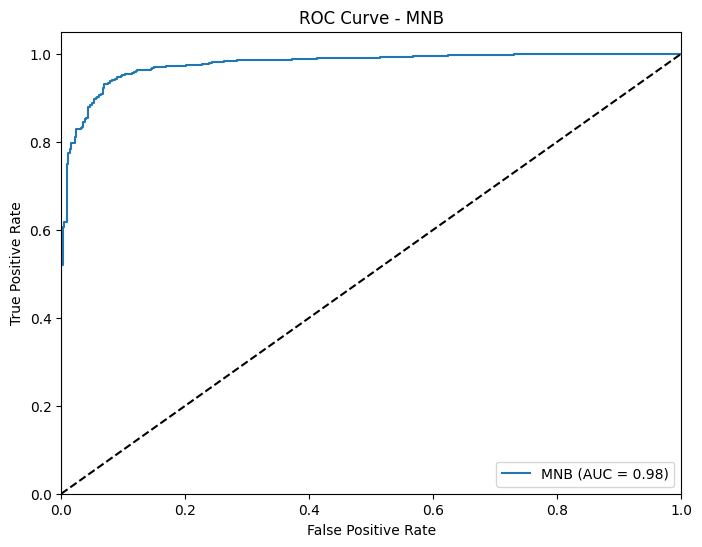

Metrics for LR:
Accuracy: 0.9323725055432373
Precision: 0.9537037037037037
Recall: 0.9094922737306843
F1 Score: 0.9310734463276836
AUC: 0.9838935677517368
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       449
           1       0.95      0.91      0.93       453

    accuracy                           0.93       902
   macro avg       0.93      0.93      0.93       902
weighted avg       0.93      0.93      0.93       902



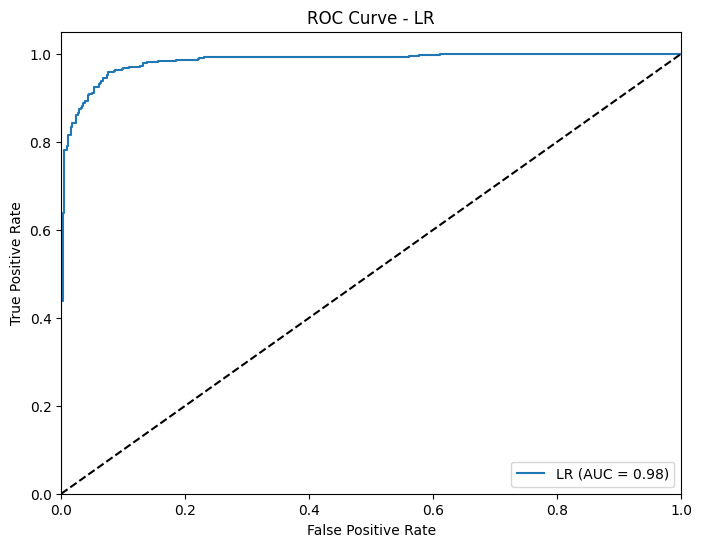

Metrics for RF:
Accuracy: 0.9423503325942351
Precision: 0.9525959367945824
Recall: 0.9315673289183223
F1 Score: 0.9419642857142857
AUC: 0.9832667148483016
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       449
           1       0.95      0.93      0.94       453

    accuracy                           0.94       902
   macro avg       0.94      0.94      0.94       902
weighted avg       0.94      0.94      0.94       902



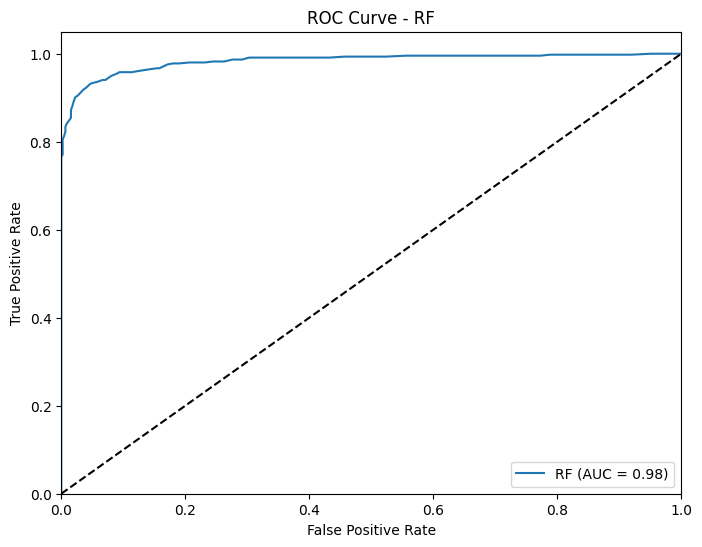

Metrics for KNN:
Accuracy: 0.852549889135255
Precision: 0.8007518796992481
Recall: 0.9403973509933775
F1 Score: 0.86497461928934
AUC: 0.9437258169982842
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       449
           1       0.80      0.94      0.86       453

    accuracy                           0.85       902
   macro avg       0.86      0.85      0.85       902
weighted avg       0.86      0.85      0.85       902



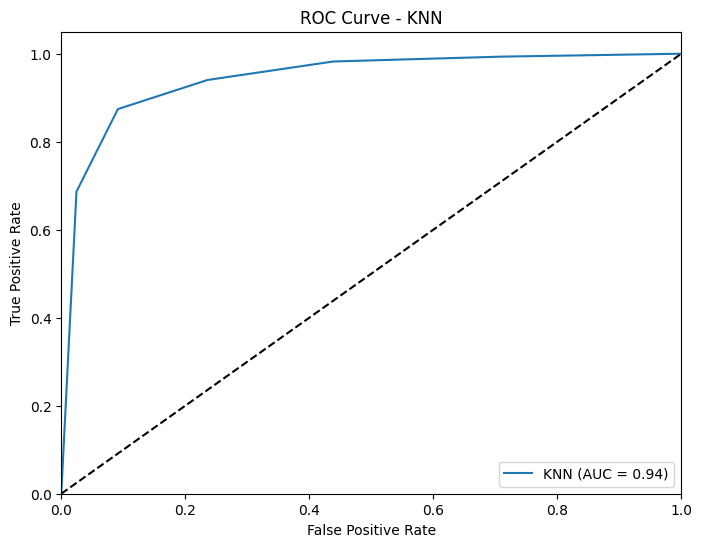

Metrics for SVM:
Accuracy: 0.9423503325942351
Precision: 0.9739952718676123
Recall: 0.9094922737306843
F1 Score: 0.9406392694063926
AUC: 0.9884560735900726
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       449
           1       0.97      0.91      0.94       453

    accuracy                           0.94       902
   macro avg       0.94      0.94      0.94       902
weighted avg       0.94      0.94      0.94       902



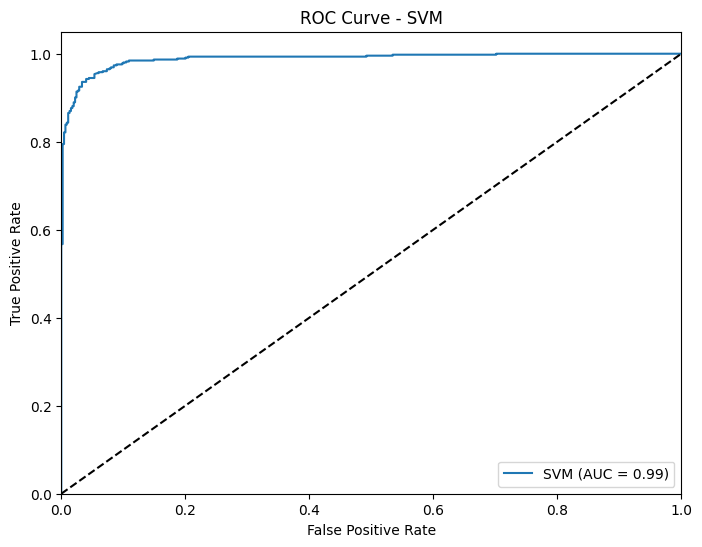

In [16]:


# Create an empty DataFrame for storing metrics
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# Evaluate base models
for model, name in  zip(base_models , base_names):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    y_prob = model.predict_proba(X_test_tfidf)[:, 1]  # Probability for positive class for ROC curve
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

Metrics for Stacking Model:
Accuracy: 0.9611973392461197
Precision: 0.960352422907489
Recall: 0.9624724061810155
F1 Score: 0.9614112458654906
AUC: 0.9925220135990206
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       449
           1       0.96      0.96      0.96       453

    accuracy                           0.96       902
   macro avg       0.96      0.96      0.96       902
weighted avg       0.96      0.96      0.96       902



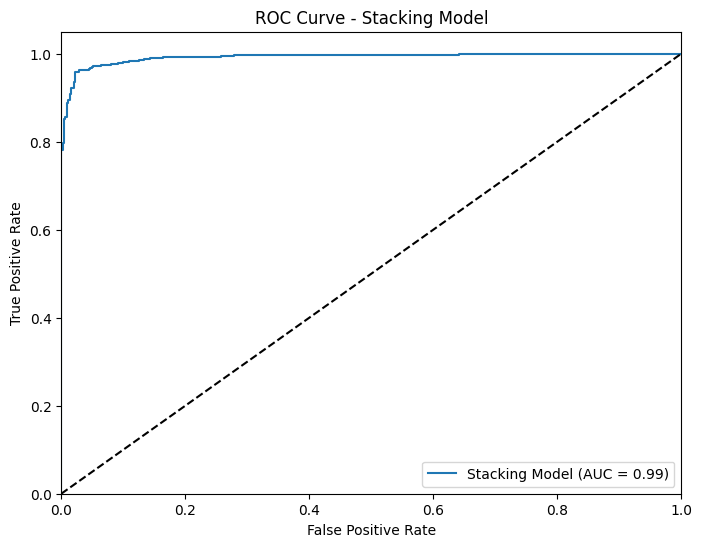

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB             0.837029  0.760204  0.986755   0.85879  0.976838
LR              0.932373  0.953704  0.909492  0.931073  0.983894
RF               0.94235  0.952596  0.931567  0.941964  0.983267
KNN              0.85255  0.800752  0.940397  0.864975  0.943726
SVM              0.94235  0.973995  0.909492  0.940639  0.988456
Stacking Model  0.961197  0.960352  0.962472  0.961411  0.992522


In [17]:
# Evaluate stacking model
stack_y_pred = stack.predict(X_test_tfidf)
stack_y_prob = stack.predict_proba(X_test_tfidf)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(y_test, stack_y_pred)
stack_precision = precision_score(y_test, stack_y_pred)
stack_recall = recall_score(y_test, stack_y_pred)
stack_f1 = f1_score(y_test, stack_y_pred)
stack_auc = roc_auc_score(y_test, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(y_test, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_test, stack_y_prob)
stack_roc_auc = roc_auc_score(y_test, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)

In [18]:
# Save the model using joblib
joblib.dump(stack, '../../ModelsV3/stackmodel_lr.joblib')

# with open('../../ModelsV2/pipeline_lr.pkl', 'wb') as f:
#     dill.dump(stack, f)

['../../ModelsV3/stackmodel_lr.joblib']